In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

In [2]:
def load(file_name):
    return pd.read_csv(file_name)

In [3]:
df = load('customer_shopping_data.csv')

In [4]:
# vis.py
def vs(df):
    sns.histplot(df['price'], bins=7, kde=False)
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    plt.title('Histogram of Prices')
    plt.savefig('vis.png')

In [5]:
# preprocessing
import sklearn
from sklearn import preprocessing

def pre(df):  
    # cleaning
    # remove duplicates
    df.drop_duplicates(subset=['gender', 'age', 'category', 'quantity','price', 'payment_method','shopping_mall'], keep='first', inplace=True)
    
    # cleaning 
    # not all dates are in the same format
    def r_format(arg):
        left_ind = arg.find('/')
        if left_ind == 1:
            arg = '0' + arg
            left_ind+=1
        if arg[left_ind+2] == '/':
            arg = arg[:left_ind+1] + '0' + arg[left_ind+1:]
        return arg
    
    df['invoice_date'] = df['invoice_date'].apply(r_format)
    df['invoice_date'] = pd.to_datetime(df['invoice_date'], format='%d/%m/%Y')
    
    
    def categorization(price,step1,step2):
        if price < step1:
            return 0
        elif price < step2:
            return 1
        else:
            return 2

    # discretizing 
    # for price column
    step1 = df.price.quantile(1/3)
    step2 = df.price.quantile(3/4)
    df['categorized_price'] = df['price'].apply(categorization,step1=step1,step2=step2)
    
    
    # discretizing
    # for age column
    step1 = df.age.quantile(1/3)
    step2 = df.age.quantile(3/4)
    df['categorized_ages'] = df['age'].apply(categorization,step1=step1,step2=step2)
    
    
    #Transformation
    df['month'] = pd.to_datetime(df['invoice_date']).dt.month
    df['year'] = pd.to_datetime(df['invoice_date']).dt.year
    df['day'] = pd.to_datetime(df['invoice_date']).dt.day
    df.drop(columns=['invoice_date','invoice_no'], inplace=True)

    
    # reduction
    df_out = df.copy()
    df_out.drop(columns=['price','month','year','day','customer_id'], inplace=True)
    
    
    # encoding categorical columns
    le = sklearn.preprocessing.LabelEncoder()
    categorical_columns = ['gender', 'category', 'payment_method', 'shopping_mall']
    for col in categorical_columns:
        df_out[col] = le.fit_transform(df_out[col])
    
    # Transformation
    standardize = preprocessing.StandardScaler()
    df_stan = standardize.fit_transform(df_out)
    
    pd.DataFrame(df_stan).to_csv('res_dpre.csv', index=False)
    
    
    
    return df_stan

In [6]:
d = pre(df)

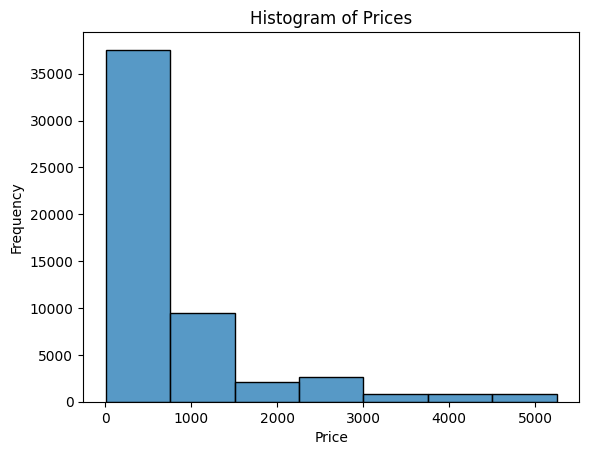

In [7]:
vs(df)

In [8]:
# EDA
from numpy import floor 
def eda1(df):
    # first
    total = floor(df.groupby(['month','year'])['customer_id'].count().groupby('month').mean())
    total.name = 'floored average number of customers per month for all year'
    total.sort_values(ascending=False, inplace=True)
    total.to_csv('eda-in-1.txt', sep='\t', index=True)

    # second
    df2 = df[['categorized_price','payment_method']]
    eda2 = df2[df2.categorized_price == 2].value_counts()
    eda2.name = 'counts of payment methods for products in the fourth quartile'
    eda2.to_csv('eda-in-2.txt', sep='\t', index=True)

    # third
    sales_df = df[['shopping_mall','price','quantity']]
    sales_df['total_sales'] = sales_df['price'] * sales_df['quantity']
    sales_df = sales_df.groupby('shopping_mall')['total_sales'].sum()
    sales_df.name = 'total sales for each shopping mall'
    sales_df.sort_values(ascending=False, inplace=True)
    sales_df.to_csv('eda-in-3.txt', sep='\t', index=True)

In [9]:
eda1(df)

C:\Users\user\AppData\Local\Temp\ipykernel_30988\3307213384.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_df['total_sales'] = sales_df['price'] * sales_df['quantity']


In [10]:
# model 
from sklearn.cluster import KMeans
def model():
    df = load('res_dpre.csv')
    kmeans_model = KMeans(n_clusters=3)
    kmeans_model.fit(df)
    labels = kmeans_model.predict(df)
    d = pd.DataFrame(df)
    d['cluster'] = labels
    values = d.cluster.value_counts()
    values.to_csv('k.txt', sep='\t', index=True)

In [11]:
model()

In [12]:
d.shape

(54200, 8)